In [1]:
import glob
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib qt 

In [ ]:
# Load the 10-20 montage
montage = mne.channels.make_standard_montage('biosemi64')
# path
oc_path = f"C:/Users/mvmigem/Documents/data/project_1/overlap_corrected/"
#make subject list
excuded_pp = [3,14,20]
subject_list = []
for sub in range(1,27):
    if sub not in excuded_pp:
        subject_list.append(sub)

# Create data object info
sfreq = 512
tmin = -0.1
channel_names = montage.ch_names
channel_types = ['eeg'] * len(channel_names)
info = mne.create_info(channel_names, sfreq, channel_types)
info.set_montage(montage)

# Define conditions
attended_states = ['attended', 'unattended']
stimulus_types = ['regular', 'odd']
visual_fields = ['up','down']
hemi_fields = ['left','right']

# init list of evoked dict per subject
evokeds_sub = []
#
for sub in subject_list:
    # Basically take the non eeg data from 1 df
    proto_df = pd.read_csv(oc_path+f'P10/corrected_P10_evoked_{sub:02}.csv')
    proto_df['visual_field'] = np.where(proto_df['position'].isin([1,2]),'up','down')
    proto_df['hemi_field'] = np.where(proto_df['position'].isin([1,4]),'left','right')
    proto_df = proto_df.drop(columns=['selected_electrode','yhat'])
    # Go over all channels and put them all in a df per subject
    for ch in channel_names:
        df = pd.read_csv(oc_path+f'{ch}/corrected_{ch}_evoked_{sub:02}.csv')
        df['visual_field'] = np.where(df['position'].isin([1,2]),'up','down')
        df['hemi_field'] = np.where(df['position'].isin([1,4]),'left','right')
        proto_df[ch] = df['yhat']
    
    # Separate the conditions and put the in a dict
    sub_evoked_dict = {}
    for att in attended_states:
        for st in stimulus_types:
            for vf in visual_fields:
                # Condition key
                condition_key = f'{att}/{st}/{vf}'
                subset = proto_df[(proto_df['attention']== att) & 
                                  (proto_df['expectation']== st) &
                                  (proto_df['visual_field']== vf)][channel_names] *1e-6
                data = subset.to_numpy().T
                evoked = mne.EvokedArray(data, info, tmin)
                evoked.apply_baseline((-.1,0))
                sub_evoked_dict[condition_key] = evoked
            for hf in hemi_fields:
                # Condition key
                condition_key = f'{att}/{st}/{hf}'
                subset = proto_df[(proto_df['attention']== att) & 
                                  (proto_df['expectation']== st) &
                                  (proto_df['hemi_field']== hf)][channel_names] *1e-6
                data = subset.to_numpy().T
                evoked = mne.EvokedArray(data, info, tmin)
                evoked.apply_baseline((-.1,0))
                sub_evoked_dict[condition_key] = evoked
    evokeds_sub.append(sub_evoked_dict)      


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

In [3]:
# Changing the structure of the data
evoked_dict = {}
for att in attended_states:
    for st in stimulus_types:
        for vf in visual_fields:
            # Condition key
            condition_key = f'{att}/{st}/{vf}'
            list_evo = [evokeds_sub[i][condition_key] for i in range(len(subject_list))]
            evoked_dict[condition_key] = mne.grand_average(list_evo)
        for hf in hemi_fields:
            # Condition key
            condition_key = f'{att}/{st}/{hf}'
            list_evo = [evokeds_sub[i][condition_key] for i in range(len(subject_list))]
            evoked_dict[condition_key] = mne.grand_average(list_evo)



Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


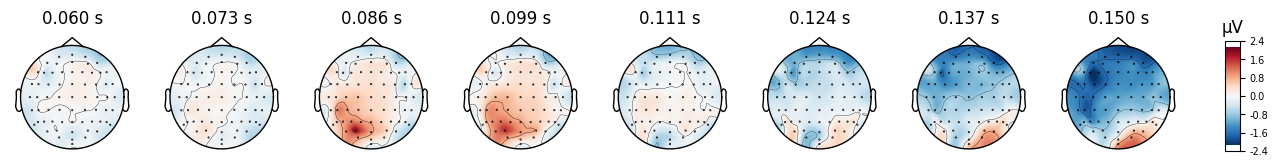

In [6]:
times = np.linspace(0.06, 0.15, 8)

evoked_dict['attended/left'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
evoked_dict['unattended/left'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
evoked_dict['attended/right'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
evoked_dict['unattended/right'].plot_topomap(ch_type="eeg", times=times, colorbar=True)

# evoked_dict['attended/regular/down'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
# evoked_dict['unattended/regular/down'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
# evoked_dict['attended/odd/down'].plot_topomap(ch_type="eeg", times=times, colorbar=True)
# evoked_dict['unattended/odd/down'].plot_topomap(ch_type="eeg", times=times, colorbar=True)

In [5]:
#agragate the different conditions
evoked_dict['attended/regular'] = mne.combine_evoked([evoked_dict['attended/regular/up'],evoked_dict['attended/regular/down']],weights='equal')
evoked_dict['attended/odd'] = mne.combine_evoked([evoked_dict['attended/odd/up'],evoked_dict['attended/odd/down']],weights='equal')
evoked_dict['unattended/regular'] = mne.combine_evoked([evoked_dict['unattended/regular/up'],evoked_dict['unattended/regular/down']],weights='equal')
evoked_dict['unattended/odd'] = mne.combine_evoked([evoked_dict['unattended/odd/up'],evoked_dict['unattended/odd/down']],weights='equal')
evoked_dict['attended'] = mne.combine_evoked([evoked_dict['attended/regular'],evoked_dict['attended/odd']],weights='equal')
evoked_dict['unattended'] = mne.combine_evoked([evoked_dict['unattended/regular'],evoked_dict['unattended/odd']],weights='equal')
evoked_dict['regular'] = mne.combine_evoked([evoked_dict['attended/regular'],evoked_dict['unattended/regular']],weights='equal')
evoked_dict['odd'] = mne.combine_evoked([evoked_dict['attended/odd'],evoked_dict['unattended/odd']],weights='equal')
evoked_dict['attended/left'] = mne.combine_evoked([evoked_dict['attended/regular/left'],evoked_dict['attended/odd/left']],weights='equal')
evoked_dict['attended/right'] = mne.combine_evoked([evoked_dict['attended/regular/right'],evoked_dict['attended/odd/right']],weights='equal')
evoked_dict['unattended/left'] = mne.combine_evoked([evoked_dict['unattended/regular/left'],evoked_dict['unattended/odd/left']],weights='equal')
evoked_dict['unattended/right'] = mne.combine_evoked([evoked_dict['unattended/regular/right'],evoked_dict['unattended/odd/right']],weights='equal')
evoked_dict['regular/left'] = mne.combine_evoked([evoked_dict['attended/regular/left'],evoked_dict['unattended/regular/left']],weights='equal')
evoked_dict['regular/right'] = mne.combine_evoked([evoked_dict['attended/regular/right'],evoked_dict['unattended/regular/right']],weights='equal')
evoked_dict['odd/left'] = mne.combine_evoked([evoked_dict['attended/odd/left'],evoked_dict['unattended/odd/left']],weights='equal')
evoked_dict['odd/right'] = mne.combine_evoked([evoked_dict['attended/odd/right'],evoked_dict['unattended/odd/right']],weights='equal')
evoked_dict['left'] = mne.combine_evoked([evoked_dict['attended/left'],evoked_dict['unattended/left']],weights='equal')
evoked_dict['right'] = mne.combine_evoked([evoked_dict['attended/right'],evoked_dict['unattended/right']],weights='equal')

In [ ]:
sdf = subset[channel_names] * 1e6